In [2]:
import numpy as np
import array as arr
from astropy import table
#from reproject import reproject_exact ;not reprojecting in here
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
import sewpy
import iterate_convolution as ic
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join
import astropy.table
from photutils import CircularAperture
from photutils import SkyCircularAperture
from photutils import aperture_photometry
#from astropy.table import join_distance
#import catalog_match_im_trans as cmit
#show how good the reprojection is by looking at deltax and deltay plots?

In [3]:
#original files to work with
file1='/home/k689j329/HSTdata/j210604m5845/j210604m5845-f606w_drc_sci.fits'
filered='/home/k689j329/HSTdata/j210604m5845/j210604m5845-f105w_drz_sci.fits'
filereprojd='/home/k689j329/HSTdata/j2106_blue2red_exact.fits'
#this reprojd file is the output of the reprojectin.py program

hrp=fits.open(filered)
hop=fits.open(file1)
hpnew=fits.open(filereprojd)




In [4]:
####not 100% sure we need to do this aside from opening hop, hrp, and hpnew and extracting header values.
#make catalog tables out of these original files
hdr_606=hop[0].header
fwhmpix606=2.5 #from earlier,manual/topcat measurements
cd1_606=hdr_606['CD1_1']
cd606_arc=abs(cd1_606) * 3600.0 #this derives the pixel scale from the header
fwhmarc606=fwhmpix606*cd606_arc 
tableoriginal=ic.makecat(file1,see=fwhmarc606,ps=cd606_arc)

hdr_reprj=hpnew[0].header
fwhmpix_reprj = 1.17 #what on EARTH should this be? ideally, it should = fwhmpix of f105w, right?
#that's after convolution. this hasn't been convolved yet. it has been reprojected, though, so the pixel scale
#has changed (as represented below)
#I think this needs to stay as fwhmpix_reprj = fwhmpix606, what we started with
cd1_reprj=hdr_reprj['CD1_1']
cdreprj_arc=abs(cd1_reprj)*3600.0
fwhmarcreprj=fwhmpix_reprj*cdreprj_arc
tablereproj=ic.makecat(filereprojd,see=fwhmarcreprj,ps=cdreprj_arc)
print('tablereproj seeing and pixel scale',fwhmarcreprj,cdreprj_arc)

hdr_105=hrp[0].header
fwhmpix105=1.95
cd1_105=hdr_105['CD1_1']
cd105_arc=abs(cd1_105)*3600.0
fwhmarc105=fwhmpix105*cd105_arc
table105=ic.makecat(filered,see=fwhmarc105,ps=cd105_arc)
print('table105 seeing and pixel scale',fwhmarc105,cd105_arc)


#print(np.amax(tableoriginal['CLASS_STAR']))
#print(np.amax(tablereproj['CLASS_STAR']))
#print(np.amax(table105['CLASS_STAR']))
#print(np.mean(table105['CLASS_STAR']))
#ah, that indicates that something in the reprojection process resets class_star to be max of 0.845


Ouch, SExtractor complains :
b''
Ouch, SExtractor complains :
b''
Ouch, SExtractor complains :
b''


tablereproj seeing and pixel scale 0.11699999999999672 0.0999999999999972
table105 seeing and pixel scale 0.19499999999999454 0.0999999999999972


In [5]:
######actually  not sure the point of this cell.

#add magnitudes to the tables
mags1=(-1.0)*np.log10(tableoriginal['FLUX_APER'])
tableoriginal['MAG']=mags1
limtableog=ic.calcfwhm(tableoriginal)
mags2=(-1.0)*np.log10(tablereproj['FLUX_APER'])
tablereproj['MAG']=mags2
limtablereproj=ic.calcfwhm(tablereproj)#,plottin=True)
magsr=(-1.0)*np.log10(table105['FLUX_APER'])
table105['MAG']=magsr
limitable105=ic.calcfwhm(table105)#,plottin=True)

#plt.scatter(limtablereproj['MAG'],limtablereproj['FWHM_IMAGE'])
#plt.scatter(limitable105['MAG'],limitable105['FWHM_IMAGE'])
#plt.show()
#look at the fwhm for reproj'd table and see if it at all relates to what we said it should be
#huh. no. nor does the fwhm for the ORIGINAL table. confused.


#xref=tabletest['X_IMAGE']
#yref=tabletest['Y_IMAGE']
#xin=tablereproj['X_IMAGE']
#yin=tablereproj['Y_IMAGE']
#septol=2.0
#this won't run until I can get catalog_match_im_trans to load somehow, and it won't (kernel dies)
#and kernel is dying because it relies on pyraf which only runs with py27 or old versions
#xoldmatch,yoldmatch,xreprjmatch,yreprjmatch,lims=cmit.cat_im_match()
#print(xoldmatch)

filtered data is size: 82
Median FWHM_IMAGE 2.05 Mean FWHM_IMAGE 2.130121951219512
filtered data is size: 120
Median FWHM_IMAGE 1.22 Mean FWHM_IMAGE 1.2198333333333333
filtered data is size: 23
Median FWHM_IMAGE 1.83 Mean FWHM_IMAGE 1.856086956521739


/home/k689j329/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


In [6]:
# iterative convolution

#do some calculations about the range of convolution kernels to try
hdr1=hrp[0].header
hdr2=hop[0].header
fwhmpixred=1.95 #from earlier,manual/topcat measurements
#cd1red=2.7777777777E-05
cd1red=hdr1['CD1_1']
cdarcred=abs(cd1red) * 3600.0
fwhmarcred= fwhmpixred*cdarcred
fwhmpixblue=2.5 #from earlier, manual/topcat measurements
#cd1blue=1.388888888E-05
cd1blue=hdr2['CD1_1']
cdarcblue=abs(cd1blue)*3600.0
fwhmarcblue=fwhmpixblue*cdarcblue
#cd reprojected?
hdrnew=hpnew[0].header
cdreproj=hdrnew['CD1_1']
cdarcreproj=abs(cdreproj)*3600.0

print('cdarcblue and cdarcreproj',cdarcblue,cdarcreproj)
#an average in-between value would be calculated like this: fwhm2=((fwhmarcred**2.0)-(fwhmarcblue**2.0))**(1/2)

print('fwhmarcblue,fwhmpixblue:',fwhmarcblue,fwhmpixblue)
print('fwhmarcred,fwhmpixred:',fwhmarcred,fwhmpixred)

#now, what exactly do we want?
#we want an average star's FWHM in the convolved image to be as close as possible to FWHM_red

yarray1=np.linspace(fwhmarcred,fwhmarcblue,15,endpoint=True)
yarray=yarray1/cdarcreproj
print(yarray)

#this was the original method of figuring out the best convolution. conv_feb217.fits turned out the closest
#next cell is all about making that more precise
#convolve the images IF they haven't been done yet
#files=[]
#i=0
#for item in yarray:
#    filename=ic.conv2Dgauss(filereprojd,item,i)
#    i+=1
#    files.append(filename)
#    print(filename)
#print('done convolving')
#
#
#calculates the fwhm_median of the convolved results
#file2=['/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb210.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb211.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb212.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb213.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb214.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb215.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb216.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb217.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb218.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb219.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb2110.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb2111.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb2112.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb2113.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb2114.fits']
#fwhmmed1=[]
#j=0
#for it in file2:
#    print(it)
#    yv=yarray[j]
#    print('convolved by fwhm',yv,'pix')
#    tab2=ic.makecat(it)
#    mag2=(-1.0)*np.log10(tab2['FLUX_APER'])
#    tab2['MAG']=mag2
#    og_limtable=ic.calcfwhm(tab2)
#    fwh_med=np.median(og_limtable['FWHM_IMAGE'])
#    fwhmmed1.append(fwh_med)
#    print('*********')
#    j+=1
    

cdarcblue and cdarcreproj 0.049999999999996804 0.0999999999999972
fwhmarcblue,fwhmpixblue: 0.124999999999992 2.5
fwhmarcred,fwhmpixred: 0.19499999999999454 1.95
[1.95 1.9  1.85 1.8  1.75 1.7  1.65 1.6  1.55 1.5  1.45 1.4  1.35 1.3
 1.25]


In [7]:
# okay time to get better convolutions
print(yarray)

ymax=yarray1[10]+0.01
ymin=yarray1[10]-0.01
ya2=np.linspace(ymax,ymin,10,endpoint=True)
yarr2=ya2/cdarcreproj
print(yarr2)

i=0
files=[]
for item in yarr2:
    filename=ic.conv2Dgauss(filereprojd,item,i)
    i+=1
    files.append(filename)
    print(filename)
print('done convolving')

[1.95 1.9  1.85 1.8  1.75 1.7  1.65 1.6  1.55 1.5  1.45 1.4  1.35 1.3
 1.25]
[1.55       1.52777778 1.50555556 1.48333333 1.46111111 1.43888889
 1.41666667 1.39444444 1.37222222 1.35      ]
already convolved
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_0.fits
already convolved
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_1.fits
already convolved
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_2.fits
already convolved
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_3.fits
already convolved
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_4.fits
already convolved
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_5.fits
already convolved
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_6.fits
already convolved
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_7.fits
already convolved
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_8.fits
already convolved
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_9.fits
done convo

In [8]:
#now need to run SE, make a table, and find out how to work with that table
#convolved j2106_f606w's best stellar sequence is fwhm_image <5 mag -2.2 to -1.0
#add a column containing ~magnitude
#outdated(newest is apr21_5)#file2=['/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb210.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb211.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb212.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb213.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb214.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb215.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb216.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb217.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb218.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb219.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb2110.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb2111.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb2112.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb2113.fits','/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb2114.fits']
#i=len(files)
fwhm_median=[]
i=0
for item in files:
    print(item)
    yval=yarr2[i] #in pixels
    print('convolved by FWHM',yval,'pixels')
    table1=ic.makecat(item)
    mags=(-1.0)*np.log10(table1['FLUX_APER'])
    table1['MAG']=mags
    #plt.plot(table1['MAG'],table1['FWHM_IMAGE'],'ro')
    #plt.title('Does the stellar sequence stay appropriate in this pre-determined range?')
    #plt.ylim(0.0,4.5)
    #plt.xlim(-2.2,-1.0)
    #plt.show()
    newlimitedtable=ic.calcfwhm(table1)
    #you can enter plottin=True as an optional argument in calcfwhm
    #that lets you see the stellar sequence that falls in the selection range used for making a new, limited table
    fwhmmed=np.median(newlimitedtable['FWHM_IMAGE'])
    fwhm_median.append(fwhmmed)
    print('-------------')
    i+=1


#okay, updated the makecat program to use SEEING_FWHM 0.195 and PIXEL_SCALE 0.1; this hopefully makes more good stars



Ouch, SExtractor complains :
b''


/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_0.fits
convolved by FWHM 1.549999999999971 pixels


Ouch, SExtractor complains :
b''


filtered data is size: 85
Median FWHM_IMAGE 1.95 Mean FWHM_IMAGE 1.9932941176470589
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_1.fits
convolved by FWHM 1.527777777777748 pixels


Ouch, SExtractor complains :
b''


filtered data is size: 84
Median FWHM_IMAGE 1.9249999999999998 Mean FWHM_IMAGE 1.960952380952381
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_2.fits
convolved by FWHM 1.5055555555555251 pixels


Ouch, SExtractor complains :
b''


filtered data is size: 87
Median FWHM_IMAGE 1.9 Mean FWHM_IMAGE 1.944252873563218
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_3.fits
convolved by FWHM 1.4833333333333023 pixels


Ouch, SExtractor complains :
b''


filtered data is size: 89
Median FWHM_IMAGE 1.88 Mean FWHM_IMAGE 1.920898876404494
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_4.fits
convolved by FWHM 1.4611111111110795 pixels


Ouch, SExtractor complains :
b''


filtered data is size: 89
Median FWHM_IMAGE 1.86 Mean FWHM_IMAGE 1.90191011235955
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_5.fits
convolved by FWHM 1.4388888888888565 pixels


Ouch, SExtractor complains :
b''


filtered data is size: 81
Median FWHM_IMAGE 1.84 Mean FWHM_IMAGE 1.8980246913580248
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_6.fits
convolved by FWHM 1.4166666666666339 pixels


Ouch, SExtractor complains :
b''


filtered data is size: 81
Median FWHM_IMAGE 1.82 Mean FWHM_IMAGE 1.8917283950617283
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_7.fits
convolved by FWHM 1.3944444444444108 pixels


Ouch, SExtractor complains :
b''


filtered data is size: 75
Median FWHM_IMAGE 1.8 Mean FWHM_IMAGE 1.8741333333333337
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_8.fits
convolved by FWHM 1.372222222222188 pixels


Ouch, SExtractor complains :
b''


filtered data is size: 83
Median FWHM_IMAGE 1.77 Mean FWHM_IMAGE 1.8389156626506027
-------------
/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_9.fits
convolved by FWHM 1.3499999999999652 pixels
filtered data is size: 93
Median FWHM_IMAGE 1.74 Mean FWHM_IMAGE 1.8203225806451608
-------------


well, originally...


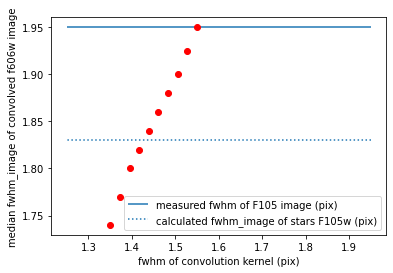

Now, going to use /home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_5.fits , which used a convolution kernel= 1.4388888888888565  and produced median fwhm= 1.84


In [9]:
#okay make a plot of those outputs


print('well, originally...')
#plt.plot(yarray,fwhmmed1,'go')
plt.plot(yarr2,fwhm_median,'ro')
plt.hlines(1.95,xmin=yarray[0],xmax=yarray[len(yarray)-1],label='measured fwhm of F105 image (pix)')
plt.hlines(1.83,xmin=yarray[0],xmax=yarray[len(yarray)-1],label='calculated fwhm_image of stars F105w (pix)',linestyle=':')
plt.xlabel('fwhm of convolution kernel (pix)')
plt.ylabel('median fwhm_image of convolved f606w image')
plt.legend()

plt.show()

#plt.plot(yarr2,fwhm_median,'ro')
#plt.hlines(fwhmpixred,xmin=yarr2[0],xmax=yarr2[len(yarr2)-1],label='measured FWHM of F105W image (Pixels)')
#plt.xlabel('FWHM of convolution kernel (pixels)')
#plt.ylabel('Median FWHM_IMAGE of convolved F606w image')
#plt.xlim(1.25,2.0)
#plt.ylim(1.6,2.4)
#plt.legend()
#plt.show()

#print(files[14], 'convolution kernel size',yarr2[14], 'produced median fwhm', fwhm_median[14])
#print('originally I should have been using', file2[8],' which used a convolution kernel size=', yarray[8], ' and produced median fhwm=',fwhmmed1[8])
#print('--')
print('Now, going to use',files[5],', which used a convolution kernel=',yarr2[5],' and produced median fwhm=',fwhm_median[5])

Ouch, SExtractor complains :
b''
/home/k689j329/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
Ouch, SExtractor complains :
b''


table105 seeing and pixel scale 0.19499999999999454 0.0999999999999972
filtered data is size: 23
Median FWHM_IMAGE 1.83 Mean FWHM_IMAGE 1.856086956521739
table blue seeing and pixel scale should be familiar 0.2039999999999943 0.0999999999999972
filtered data is size: 78
Median FWHM_IMAGE 1.84 Mean FWHM_IMAGE 1.8984615384615382


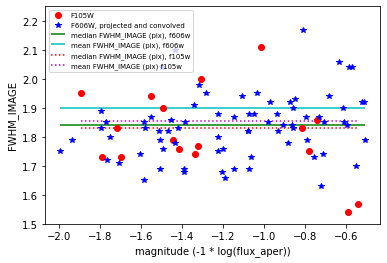

/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_5.fits


In [10]:
#######this is all setting up 'stellar sequence' plots and comparisons

goodfilered=filered
hrp=fits.open(goodfilered)
goodfileblue=files[5]

#since feb217 is the 'good one', the best convolution, let's look at the stellar sequence of that compared to F105w
hdr_105=hrp[0].header
fwhmpix105=1.95
cd1_105=hdr_105['CD1_1']
cd105_arc=abs(cd1_105)*3600.0
fwhmarc105=fwhmpix105*cd105_arc
table105=ic.makecat(goodfilered,see=fwhmarc105,ps=cd105_arc)
print('table105 seeing and pixel scale',fwhmarc105,cd105_arc)
magsr=(-1.0)*np.log10(table105['FLUX_APER'])
table105['MAG']=magsr
limitable105=ic.calcfwhm(table105)

blueimage=goodfileblue
hdb=fits.open(blueimage)
hdr_blue2=hdb[0].header
#fpixb=1.95
fpixb=2.04
#gack. where does fpixb come from again? may need to re-measure it
cd_blue2=hdr_blue2['CD1_1']
cd_arcblue2= abs(cd_blue2)*3600.0
farcb=fpixb*cd_arcblue2
tab_blu=ic.makecat(blueimage,see=farcb,ps=cd_arcblue2)
print('table blue seeing and pixel scale should be familiar',farcb,cd_arcblue2)
mblu=(-1.0)*np.log10(tab_blu['FLUX_APER'])
tab_blu['MAG']=mblu
limblu=ic.calcfwhm(tab_blu)

plt.plot(limitable105['MAG'],limitable105['FWHM_IMAGE'],'ro',label='F105W')
plt.plot(limblu['MAG'],limblu['FWHM_IMAGE'],'b*',label='F606W, projected and convolved')
plt.hlines(np.median(limblu['FWHM_IMAGE']),xmin=np.min(limblu['MAG']),xmax=np.max(limblu['MAG']),color='g',label='median FWHM_IMAGE (pix), f606w')
plt.hlines(np.mean(limblu['FWHM_IMAGE']),xmin=np.min(limblu['MAG']),xmax=np.max(limblu['MAG']),color='c',label='mean FWHM_IMAGE (pix), f606w')
plt.hlines(np.median(limitable105['FWHM_IMAGE']),xmin=np.min(limitable105['MAG']),xmax=np.max(limitable105['MAG']),linestyle=':',color='r',label='median FWHM_IMAGE (pix), f105w')
plt.hlines(np.mean(limitable105['FWHM_IMAGE']),xmin=np.min(limitable105['MAG']),xmax=np.max(limitable105['MAG']),color='m',linestyle=':',label='mean FWHM_IMAGE (pix) f105w')
#plt.hlines(1.95,xmin=yarray[0],xmax=yarray[len(yarray)-1],label='measured FWHM of F105W image (Pixels)')
plt.xlabel('magnitude (-1 * log(flux_aper))')
plt.ylim(1.5,2.25)
plt.ylabel('FWHM_IMAGE')
plt.legend(fontsize='x-small',loc="upper left")
plt.show()

print(files[5])


#plt.scatter(limtablereproj['MAG'],limtablereproj['FWHM_IMAGE'])
#plt.scatter(limitable105['MAG'],limitable105['FWHM_IMAGE'])
#plt.show()

OKAY all of that above tells me that
the best fit is /home/k689j329/HSTdata/j2106_blue2red_exact_conv_apr21_5.fits
so, time to make curve of growth plots comparing red and convolved blue distributions of flux

Output catalog /home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_5.fits.cat.txt already exists, I will overwrite it
Ouch, SExtractor complains :
b''


/home/k689j329/HSTdata/j2106_blue2red_exact_conv_aug21_5.fits
high class_star and no flags 761
just no flags 3089


/home/k689j329/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


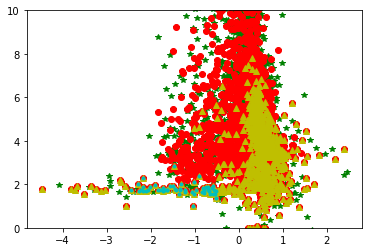

In [11]:
#file_blue='/home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb217.fits'
file_blue=files[5]
print(file_blue)
file_red='/home/k689j329/HSTdata/j210604m5845/j210604m5845-f105w_drz_sci.fits'
#%matplotlib inline
#make a catalog from dual image mode sextractor
see=fwhm_median[5]
ps=cdarcred
sew=sewpy.SEW(params=["ALPHA_J2000","DELTA_J2000","FWHM_IMAGE","FLUX_APER","X_IMAGE","Y_IMAGE","FLAGS","CLASS_STAR"],config={"DETECT_MINAREA":5, "DETECT_THRESH":1.5,"ANALYSIS_THRESH":1.5,"PHOT_APERTURES":5,"SEEING_FWHM":see,"PIXEL SCALE":ps},sexpath="sextractor")
mixe=sew(file_red,file_blue)
mixtable=mixe["table"]

#add magnitudes to the table, and then sort out high class_star objects and objects without flags
mags=(-1.0)*np.log10(mixtable['FLUX_APER'])
mixtable['MAG']=mags
#fig,ax=plt.subplots()
#%matplotlib inline
plt.plot(mixtable['MAG'],mixtable['FWHM_IMAGE'],'g*')

goodstar=mixtable['CLASS_STAR'] > 0.7
noflags=mixtable['FLAGS'] < 0.9
goodmixtable=mixtable[np.logical_and(goodstar,noflags)]
print('high class_star and no flags',len(goodmixtable))
noflagtable=mixtable[noflags]
print('just no flags',len(noflagtable))
plt.plot(noflagtable['MAG'],noflagtable['FWHM_IMAGE'],'ro')
plt.plot(goodmixtable['MAG'],goodmixtable['FWHM_IMAGE'],'y^')

plt.ylim(0,10)


#okay, long story short I should pick out  more star things earlier on, looks like class_star doesn't do enough
betterstar=goodmixtable['FWHM_IMAGE'] < 3.0
betstarx=(goodmixtable['MAG'] < -0.5) & (goodmixtable['MAG'] > -2.5)

beststarsever=goodmixtable[np.logical_and(betstarx,betterstar)]
plt.plot(beststarsever['MAG'],beststarsever['FWHM_IMAGE'],'c.')
plt.show()
#outregions=list()
#leny=len(mixtable)
#print(leny)
#j=0
#while j < (leny):
#    x=mixtable[j]['X_IMAGE']
#    y=mixtable[j]['Y_IMAGE']
#    out1='circle('+str(x)+','+str(y)+',10)'
#    outregions.append(out1)
#    j+=1    
#f=open('/home/k689j329/HSTdata/j2106_b2rec_feb217_sewpy_v2.reg','a+')
#f.writelines("%s\n" % item for item in outregions)
#f.close()


In [77]:
#turn catalogs into 'skycoord?'
#I can turn goodmixtable into noflagtable to make sure it's not just stellar things nearby
#but going from 600 to 3000 sources is gonna be interestingly computationally difficult. maybe. let's try it.
#and I mean we are looking for stars that'll be good to do curve of growth on. soooo maybenot
gmt_cat=SkyCoord(ra=beststarsever['ALPHA_J2000'],dec=beststarsever['DELTA_J2000'])
#gmt1=gmt_cat[0]
#outs=gmt1.separation(gmt_cat)

#calculate separation
holdseps=[]
for x in gmt_cat:
    sep=x.separation(gmt_cat)
    holdseps.append(sep.arcsecond)


#selfmatch 
#okay let's try this.
print(len(holdseps[1]))
indxs_notself=[]
for i in range(0,len(holdseps)):
    selff=holdseps[i][i]
    indx=np.where(holdseps[i] != selff)
    holdseps[i]=holdseps[i][np.where(holdseps[i] != selff)]
    indxs_notself.append(indx)
#okay that picks out the self matches.
#print(len(holdseps[1]))

for x in holdseps:
    x=x.sort()

maybegoodstars=[]
for x in holdseps:
    good=all(x >= 8.0)
    maybegoodstars.append(good)

goodstar_candidates=beststarsever[maybegoodstars]
#print(goodstar_candidates['MAG'].data)

#aHA, having adjusted the MAG features above when sorting out a good catalog to look at
#these steps below are no longer important
beststars=goodstar_candidates
#plt.show()
#notsat=np.where((goodstar_candidates['FLUX_APER'] > 1) & (goodstar_candidates['FLUX_APER'] <1000))
#beststars=goodstar_candidates[notsat]
#plt.plot(beststars['MAG'].data,beststars['FWHM_IMAGE'].data,'g*')
#plt.show

print('*************************************************************')
print('******************Above this was all set up of good stars for Curve of Growth plotting***********************************')
print('*************************************************************')

# make region files for all curve of growth candidates to verify they are reasonably positioned via ds9
#j=0
#outses=[]
#while j < (len(beststars)):
#    x=beststars[j]['X_IMAGE']
#    y=beststars[j]['Y_IMAGE']
#    out1='circle('+str(x)+','+str(y)+',10)'
#    outses.append(out1)
#    j+=1    
#f=open('/home/k689j329/HSTdata/j2106_b2rec_mar217_curveofgrowth_candidates.reg','a+')
#f.writelines("%s\n" % item for item in outses)
#f.close()



55
*************************************************************
******************Above this was all set up of good stars for Curve of Growth plotting***********************************
*************************************************************


In [94]:
#now, let's do aperture photometry
#using pix* "/pix, set up the aperture size for the normalization flux 
fullflux_d = 8.0 *(beststars['FWHM_IMAGE']*ps)
x=beststars['FWHM_IMAGE'][0]

fullflux_r = 0.5*fullflux_d
#print(min(fullflux_r),max(fullflux_r),np.average(fullflux_r))

fullflux_radius=np.median(fullflux_r)*u.arcsec


#Define the apertures, the data, and the relevant positions
hrp=fits.open(file_red)
hb2rp=fits.open(file_blue)

data105=hrp[0].data
wcs105=WCS(hrp[0].header)
datab2r=hb2rp[0].data
wcsb2r=WCS(hb2rp[0].header)

ra=[]
dec=[]
for obj in beststars:
    posra=obj['ALPHA_J2000']*u.deg
    posdec=obj['DELTA_J2000']*u.deg
    ra.append(posra)
    dec.append(posdec)
positions=SkyCoord(ra,dec)

radnounits=[0.05,0.10,0.15,0.20,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.9,1.0,1.1,1.2]
rad=[0.05,0.10,0.15,0.20,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.9,1.0,1.1,1.2]*u.arcsec #in arcsec
print('number of radii',len(rad))


phot_data105={}
phot_datab2r={}
i=0
xs=[]
ys=[]
#note from Greg--don't name IDs with x/y cuz can confuse with coords xy
while i < len(positions):
    xs.append('x'+str(i))
    ys.append('y'+str(i))
    i+=1

norm105={}
for idx,obj in enumerate(positions):
    idn=xs[idx]
    hold=[]
    apful=SkyCircularAperture(obj,r=fullflux_radius)
    apfull=apful.to_pixel(wcs105)
    fullphot=aperture_photometry(data105,apfull)
    norm105[idn]=fullphot
    for rd in rad:
        ap1=SkyCircularAperture(obj,r=rd)
        appix=ap1.to_pixel(wcs105)
        phot105=aperture_photometry(data105,appix)
        hold.append(phot105)
    phot_data105[idn]=hold

#oops this screws things up   phot_data105[idn+'_full']=fullphot
    
#print(phot_data105['x0_full'])
#print(phot_data105['x0'][19])

normb2r={}
for idx2,obj2 in enumerate(positions):
    idn2=ys[idx2]
    hold2=[]
    ap2f=SkyCircularAperture(obj2,r=fullflux_radius)
    apfl2=ap2f.to_pixel(wcsb2r)
    fullphot2=aperture_photometry(datab2r,apfl2)
    normb2r[idn2]=fullphot2
    for rd1 in rad:
        ap2=SkyCircularAperture(obj2,r=rd1)
        appix2=ap2.to_pixel(wcsb2r)
        photb2r=aperture_photometry(datab2r,appix2)
        hold2.append(photb2r)
    phot_datab2r[idn2]=hold2

#print('oops?',list(phot_data105))

######NOW, reordering all this for ease of graphing I guess.############
phot_data105_sorted={}
for ob in xs:
    stars=phot_data105[ob]
    a=[]
    b=0
    for boj in stars:
        b=boj['aperture_sum'][0]
        a.append(b)
    alldat={'id':str(ob),'norm':norm105[str(ob)],'center_coords':[stars[0]['xcenter'][0],stars[0]['ycenter'][0]],'radii':radnounits,'apsum':a}
    phot_data105_sorted[str(ob)]=alldat


    
phot_datab2r_sorted={}
for ob2 in ys:
    stary=phot_datab2r[ob2]
    c=[]
    d=0
    for job in stary:
        d=job['aperture_sum'][0]
        c.append(d)
    alldat2={'id':str(ob2),'norm':normb2r[str(ob2)],'center_coords':[stary[0]['xcenter'][0],stary[0]['ycenter'][0]],'radii':radnounits,'apsum':c}
    phot_datab2r_sorted[str(ob2)]=alldat2   
    
print(list(phot_datab2r_sorted))
print(list(phot_data105_sorted['x0']))



number of radii 20
['y0', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17', 'y18', 'y19', 'y20', 'y21', 'y22', 'y23', 'y24', 'y25', 'y26', 'y27', 'y28', 'y29', 'y30', 'y31', 'y32', 'y33', 'y34', 'y35']
['id', 'norm', 'center_coords', 'radii', 'apsum']
3525.8688854443667


36


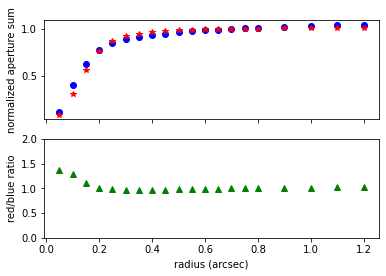

3525.8688854443667 2772.533619281831


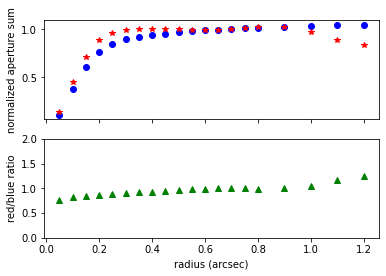

3284.582997727152 2842.1481917057986


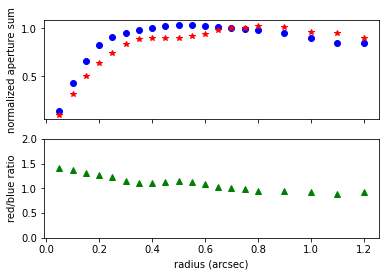

2816.0135690280676 2927.5494808839503


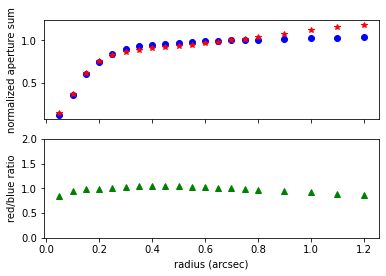

3940.8046198264556 2973.004127397595


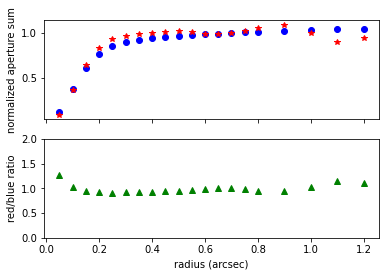

2730.2680487481443 3079.215795240428


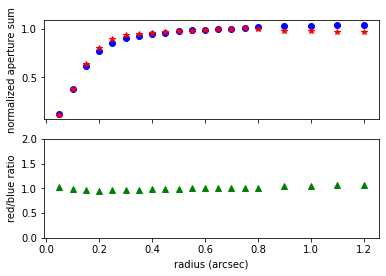

3328.4820453940065 3104.0308062134927


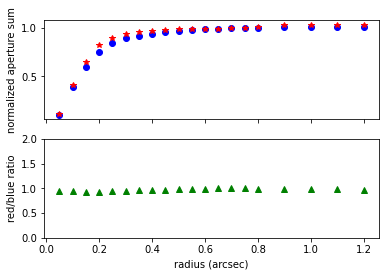

3892.585892924757 3142.6338209757705


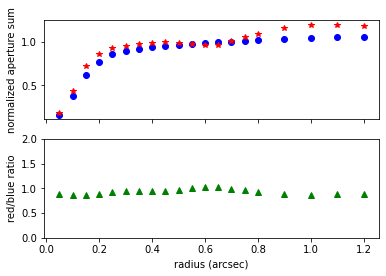

3020.9471054865153 3156.9502448542003


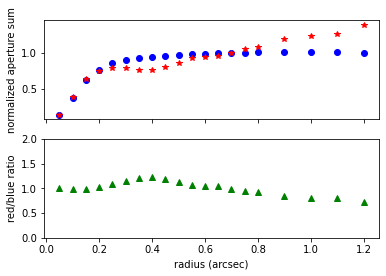

3755.1839558407883 3225.1143706733246


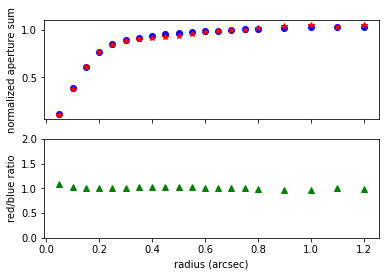

2784.4295178676175 3299.779934023425


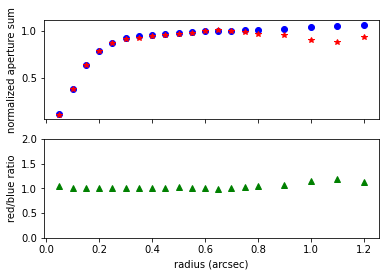

3918.596772980759 3309.1649514903756


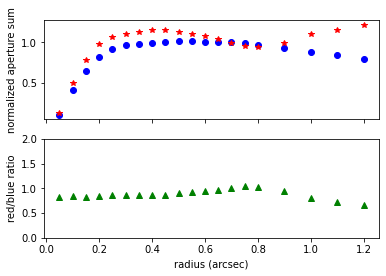

3609.578323060771 3340.3633293417224


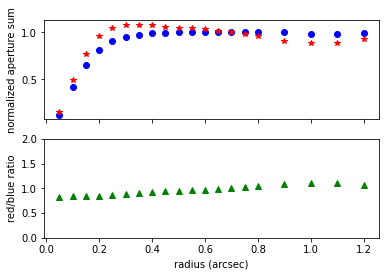

3187.3579882327736 3368.2742180471323


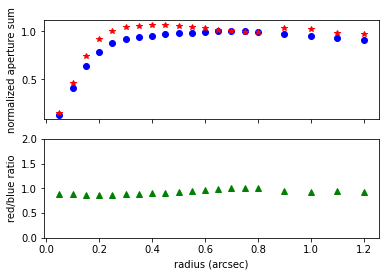

3267.6758596580717 3399.830777052544


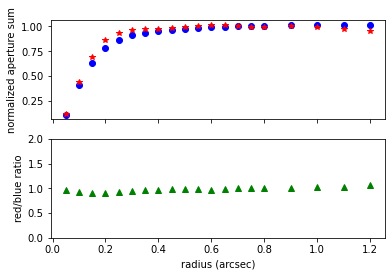

2951.6356799905793 3429.624388720702


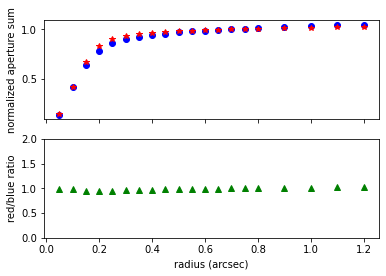

2416.738567022112 3508.2236396639914


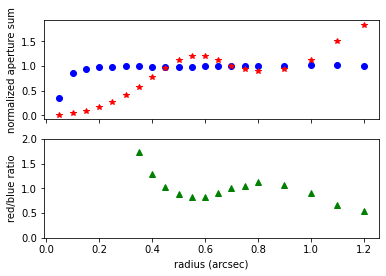

4095.0050746995175 3457.496685727022


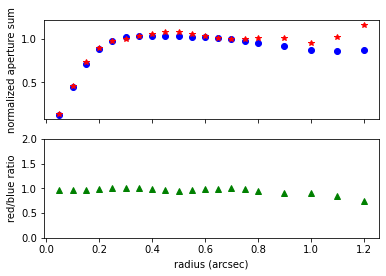

3485.672437532541 3457.673517537314


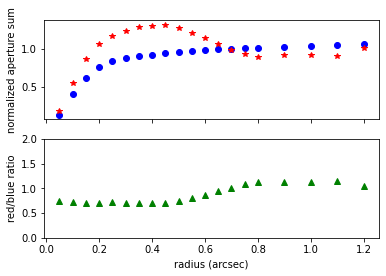

3161.4661674818617 3557.9551366615688


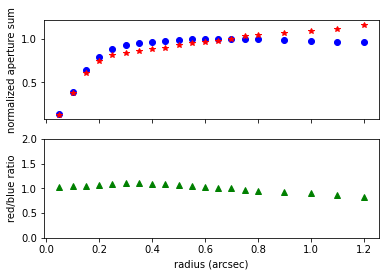

3561.674103233712 3568.937367505887


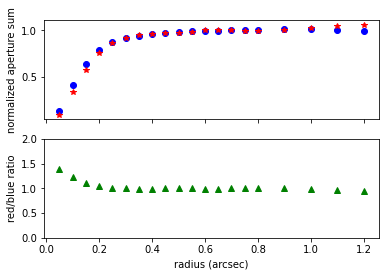

3492.278433950253 3620.7166464454276


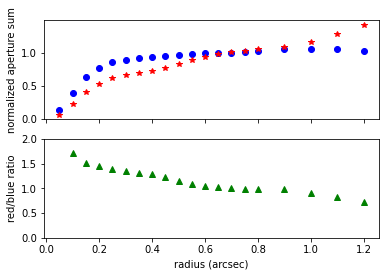

3402.8847555850057 3620.2647054405115


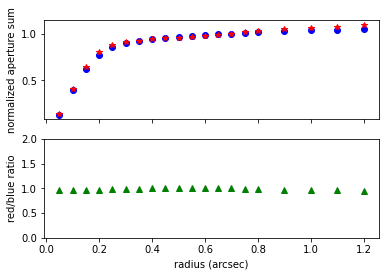

3046.892903043558 3652.3630692690945


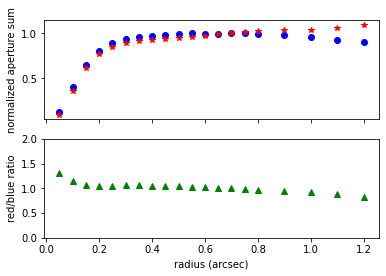

2643.354054565706 3648.828494770879


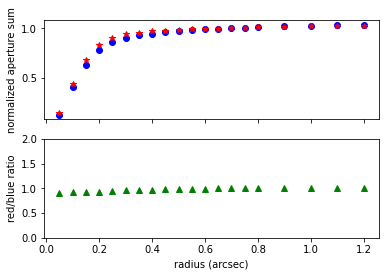

3638.5068530393637 3722.096800953356


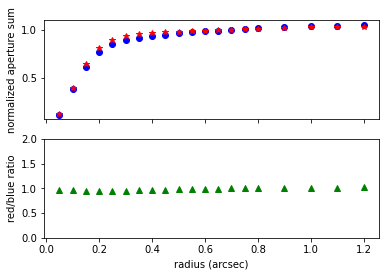

3013.290189188094 3725.283998674044


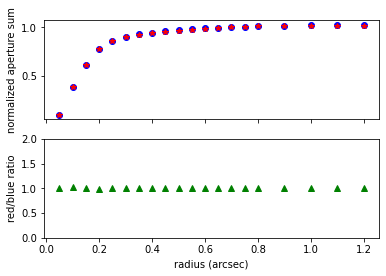

3742.6936517384547 3730.537058124528


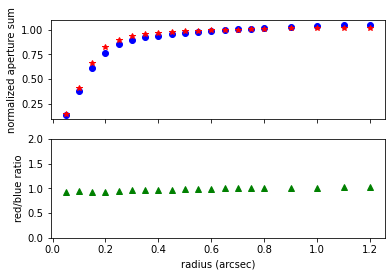

3335.9190060978835 3815.7543623246574


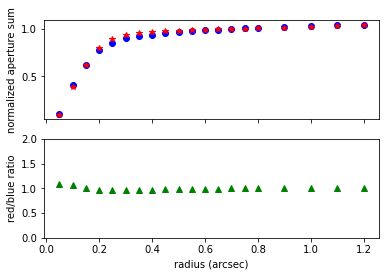

3059.430307276504 3835.5265839179


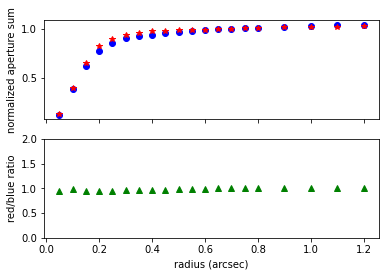

3573.640219163091 3848.9034442541706


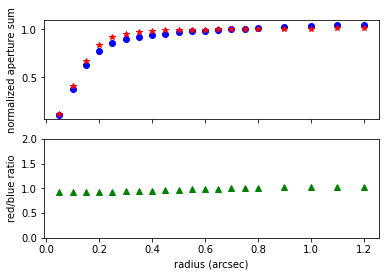

2460.532961382425 3876.8515170300407


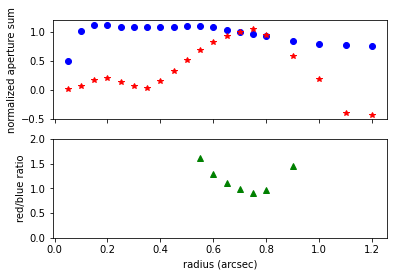

3908.004873280661 3995.686453933032


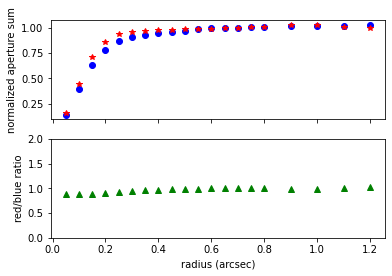

3421.962519079731 4016.3101614143766


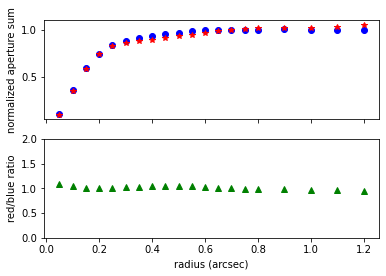

2751.1747199453057 4057.6732907138153


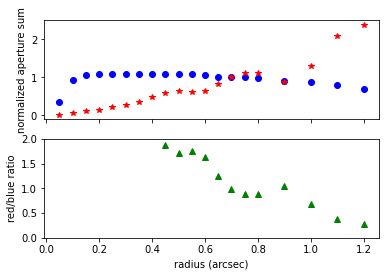

3844.2108481710384 4086.3194145712296


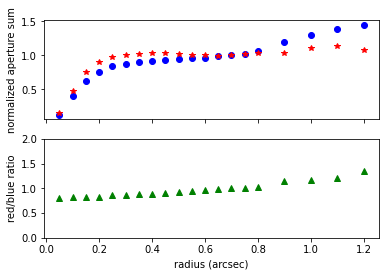

3114.4233525725804 4129.930592763121


In [97]:
#Curve of Growth Plots
#okay, try to loop
#norm105=obj105['norm']['aperture_sum'][0]
#normb2r=objb2r['norm']['aperture_sum'][0]
#norm105=phot_data105_sorted['x0']['norm']['aperture_sum'][0]
#normb2r=phot_datab2r_sorted['y0']['norm']['aperture_sum'][0]
#print(norm105,normb2r)

i=0

alldata105=[]
alldatab2r=[]
while i < len(phot_data105_sorted):
    id1='x'+str(i)
    id2='y'+str(i)
    o105=phot_data105_sorted[id1]
    ob2r=phot_datab2r_sorted[id2]
    alldata105.append(o105)
    alldatab2r.append(ob2r)
    i+=1

obj105=phot_data105_sorted['x0']
objb2r=phot_datab2r_sorted['y0']
obj105_center=obj105['center_coords']
objb2r_center=objb2r['center_coords']
#print('do these x coord match?',obj105_center[0].value,objb2r_center[0].value,obj105['norm']['xcenter'].value,objb2r['norm']['xcenter'].value)
#print('y coord match?',obj105_center[1].value,objb2r_center[1].value,obj105['norm']['ycenter'].value,objb2r['norm']['ycenter'].value)


%matplotlib inline
#%matplotlib notebook


#fig,ax1=plt.subplots(len(alldata105),2)
print(len(alldata105))
j=0
while j < len(alldata105):
    id1='x'+str(j)
    id2='y'+str(j)
    norm105=phot_data105_sorted[id1]['norm']['aperture_sum'][0]
    normb2r=phot_datab2r_sorted[id2]['norm']['aperture_sum'][0]
    fig,ax=plt.subplots(2,1,sharex=True)
    ax[0].plot(alldata105[j]['radii'],(alldata105[j]['apsum']/norm105),'bo')
    ax[0].plot(alldatab2r[j]['radii'],(alldatab2r[j]['apsum']/normb2r),'r*')
    ax[1].plot(alldata105[j]['radii'],((alldata105[j]['apsum']/norm105)/(alldatab2r[j]['apsum']/normb2r)),'g^')
    plt.xlabel('radius (arcsec)')
    ax[1].set_ylim(0,2)
    ax[0].set_ylabel('normalized aperture sum')
    ax[1].set_ylabel('red/blue ratio')
#    ax1[j,0].plot(alldata105[j]['radii'],(alldata105[j]['apsum']/norm105),'bo')
#    ax1[j,0].plot(alldatab2r[j]['radii'],(alldatab2r[j]['apsum']/normb2r),'r*')
    plt.show()
    print(phot_data105_sorted[id1]['center_coords'][0].value, phot_data105_sorted[id1]['center_coords'][1].value)
    j+=1

#was working here
# https://photutils.readthedocs.io/en/stable/aperture.html#defining-your-own-custom-apertures
# https://docs.astropy.org/en/stable/api/astropy.table.QTable.html#astropy.table.QTable
# https://docs.astropy.org/en/stable/table/access_table.html

#checkthesestars
a1=[3284.582997727152,2842.1481917057986]
a2=[3755.1839558407883,3225.1143706733246]
a3=[3609.578323060771,3340.3633293417224]
a4=[3187.3579882327736,3368.2742180471323]
a5=[3267.6758596580717,3399.830777052544]
a6=[4095.0050746995175,3457.496685727022]
a7=[3161.4661674818617,3557.9551366615688]
a8=[3402.8847555850057,3620.2647054405115]
a9=[3908.004873280661,3995.686453933032]
a10=[3844.2108481710384,4086.3194145712296]
a11=[3114.4233525725804,4129.930592763121]
aas=[a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11]
asuperweird=[a6,a7,a9,a10]

outas=[]
for ite in asuperweird:
    x=ite[0]
    y=ite[1]
    out1='circle('+str(x)+','+str(y)+',10)'
    outas.append(out1)
    j+=1    
f=open('/home/k689j329/HSTdata/j2106_b2rec_apr21_5_superweird_curveofgrowth_candidates.reg','a+')
f.writelines("%s\n" % item for item in outas)
f.close()

In [ ]:
#these three lines don't run, mostly because appy turns out to be a list object
#appy=[SkyCircularAperture(positions[0],r=rd) for rd in rad]
#appix=appy.to_pixel(wcs105)
#phottable=aperture_photometry(data105,appix)

#phot_data105=np.zeros(((len(positions)-1),(len(rad)-1)))
#k=0
#m=0
#while k < (len(positions)-1):
#    while m < (len(rad)-1):
#        ap1 = SkyCircularAperture(positions[k],r=rad[m])
#        appix=ap1.to_pixel(wcs105)
#        phot_data105[k,m] = aperture_photometry(data105,appix)
#        m+=1
#    k+=1
#ah, this only produces the last one
#the thing is, looping over position is fine but I want it to be sorted by positions and then radii; so like
#when it makes the list/phot table, there will be 20 entries with the same x_center/y_center and different radii
#then I changed it to a while loop and screwed everything up arrgh




######this chunk works for xs but not for ys--consequence of globals thing? hmm problem
#while i < len(positions):
#    globals()['x'+str(i)] = []
#    phot_data105.append(globals()['x'+str(i)])
#    phot_datab2r.append(globals()['y'+str(i)])
#    i+=1
#
#for idx,obj in enumerate(phot_data105):
#    for rd in rad:
#        ap1=SkyCircularAperture(positions[idx],r=rd)
#        appix=ap1.to_pixel(wcs105)
#        phot105=aperture_photometry(data105,appix)
#        obj.append(phot105)
#        
#for idx2,obj2 in enumerate(phot_datab2r):
#    for rd in rad:
#        ap2=SkyCircularAperture(positions[idx2],r=rd)
#        appix2=ap2.to_pixel(wcsb2r)
#        photb2r=aperture_photometry(datab2r,appix2)
#        obj2.append(photb2r)        
#print(y24)
######
    
###this is ok, but doesn't sort by object so comparison will be a bit harder    
#phot_data105=[]
#for pos in positions:
#    for rd in rad:
#        ap1=SkyCircularAperture(pos,r=rd)
#        appix=ap1.to_pixel(wcs105)
#        phots=aperture_photometry(data105,appix)
#        phot_data105.append(phots)
###
 
#########################old inprogress bits. IGNORE###########
#print(phot_data105[18:25])

#ap1=SkyCircularAperture(positions,r=0.5*u.arcsec)
#ap2=ap1.to_pixel(wcs105)
#phottest=aperture_photometry(data105,ap2)
#aper=[]
#test=positions[1]
#print(test)
#ap1=SkyCircularAperture(test,r=0.1*u.arcsec)
#for pos in positions:
#    for rd in rad:
#        ap1=SkyCircularAperture(pos,r=rd)
#        aper_pix=ap1.to_pixel(wcs105)
#        aps=np.array(aper_pix)
#    aper.append(aps)
    
#CONVERTTOPIXEL OBJ NOT SKYCOORD
   
#fullaper=[SkyCircularAperture(positions,r=f) for f in fullfluxr]
#fullrad=[]
#change this to just a number not an array
#for n in fullflux_d:
#    x=n/2
#    fullrad.append(x)
#fullfluxr=fullrad*u.arcsec
##radii = rad*ps #in pixels
#Perform photometry
#phots_105=aperture_photometry(data105,aper)

#normalize results by fullflux
#plot results

In [1]:
##below here is all not accurate
print('below here is obsolete')

below here is obsolte


In [14]:
#okay the best fit is /home/k689j329/HSTdata/j2106_blue2red_exact_conv_feb217.fits
#make a region file based on the best stars
#print(files[7])
tablebest=ic.makecat(files[5])
mags=(-1.0)*np.log10(tablebest['FLUX_APER'])
tablebest['MAG']=mags
newlimbest=ic.calcfwhm(tablebest)
#evenmorelim=newlimbest
evenmorelim=newlimbest[np.where(newlimbest['CLASS_STAR'] > 0.83)]

#plt.plot(evenmorelim['MAG'],evenmorelim['CLASS_STAR'],'ro')
#plt.show()
fwhmmed=np.median(evenmorelim['FWHM_IMAGE'])
print(fwhmmed)

outregions=list()
leny=len(evenmorelim)
print(leny)
j=0
while j < (leny):
    x=evenmorelim[j]['X_IMAGE']
    y=evenmorelim[j]['Y_IMAGE']
    out1='circle('+str(x)+','+str(y)+',10)'
    outregions.append(out1)
    j+=1
    
#f=open('/home/k689j329/HSTdata/j2106_blue2red_stars2.reg','a+')
#f.writelines("%s\n" % item for item in outregions)
#f.close()


Ouch, SExtractor complains :
b''


filtered data is size: 81
Median FWHM_IMAGE 1.84 Mean FWHM_IMAGE 1.8980246913580248
1.8450000000000002
62
